# Demo: Search Ranking Pipeline

This notebook demonstrates an end-to-end learning-to-rank pipeline using the LightGBM model.  
It includes data processing, model training, prediction, and evaluation.

*Rough version, will be polished soon*

In [52]:
# Environment Setup

import os
import sys
import torch
import shap
import graphviz
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets as ds

sys.path.append(os.path.abspath("src"))

# Project Modules
from features.lgbmodule import LightGBMWithNN
from utils.data_format_read import read_dataset
from utils.ndcg import validate
from models.lightgbm import (
    process_data_format,
    train,
    predict,
    load_data_from_raw,
    load_data,
    test_data_ndcg,
    get_leaf_index
)

# Project paths
base_path = "data"
raw_data_path = os.path.join(base_path, "train", "raw_train.txt")
data_feats = os.path.join(base_path, "train", "feats.txt")
data_group = os.path.join(base_path, "train", "group.txt")
model_path = os.path.join(base_path, "model", "model.txt")

In [53]:
# Step 1: Process training data to LightGBM format
process_data_format(raw_data_path, data_feats, data_group)

In [54]:
with open(data_feats) as f:
    for i in range(3):
        print(f.readline())                 

0 1:0.007477 3:1.000000 5:0.007470 11:0.471076 13:1.000000 15:0.477541 16:0.005120 18:0.571429 20:0.004806 21:0.768561 22:0.727734 23:0.716277 24:0.582061 29:0.780495 30:0.962382 31:0.999274 32:0.961524 37:0.797056 38:0.697327 39:0.721953 40:0.582568 46:0.007042

0 1:0.603738 3:1.000000 5:0.603175 13:0.122130 16:0.998377 17:0.375000 18:1.000000 20:0.998128 23:0.154578 24:0.555676 29:0.071711 39:0.117399 40:0.560607 42:0.280000 44:0.003708 45:0.333333 46:1.000000

0 1:0.214953 5:0.213819 11:0.401330 15:0.402388 16:0.140868 17:1.000000 18:0.285714 19:0.333333 20:0.141484 21:0.561349 22:0.771015 23:0.753872 24:1.000000 37:0.566409 38:0.760916 39:0.746370 40:1.000000 44:1.000000 45:1.000000 46:0.021127



In [55]:
# Step 2: Train LightGBM Ranker
x_train, y_train, q_train = load_data(data_feats, data_group)

params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1,
}

train_data = lgb.Dataset(x_train, y_train, group=q_train)
model = lgb.train(params, train_data, num_boost_round=100)

# Save model
model.save_model(model_path)


In [56]:
# Step 3: Predict on test set
test_path = os.path.join(base_path, "test", "test.txt")
test_X, test_y, test_qids, comments = load_data_from_raw(test_path)

scores = model.predict(test_X)
top_indices = scores.argsort()[::-1][:10]

print("Top 10 ranked results:")
for idx in top_indices:
    print(comments[idx].strip())


Top 10 ranked results:
docid = GX242-59-13762020 inc = 0.0572053271023841 prob = 0.700148
docid = GX229-77-15614690 inc = 1 prob = 0.851179
docid = GX047-36-2676876 inc = 0.0875927172611393 prob = 0.884953
docid = GX262-87-11772191 inc = 1 prob = 0.482963
docid = GX011-31-13425753 inc = 0.0154467296313992 prob = 0.526671
docid = GX037-52-5326539 inc = 0.00323493558725109 prob = 0.10662
docid = GX004-63-6330876 inc = 1 prob = 0.947487
docid = GX021-43-14489209 inc = 1 prob = 0.208155
docid = GX005-19-14475668 inc = 1 prob = 0.617954
docid = GX011-63-11382768 inc = 1 prob = 0.889478


In [57]:
# Step 4: Evaluate with NDCG
test_data_ndcg(model_path, test_path)

All QIDs average NDCG: 0.5695251427709948


np.float64(0.5695251427709948)

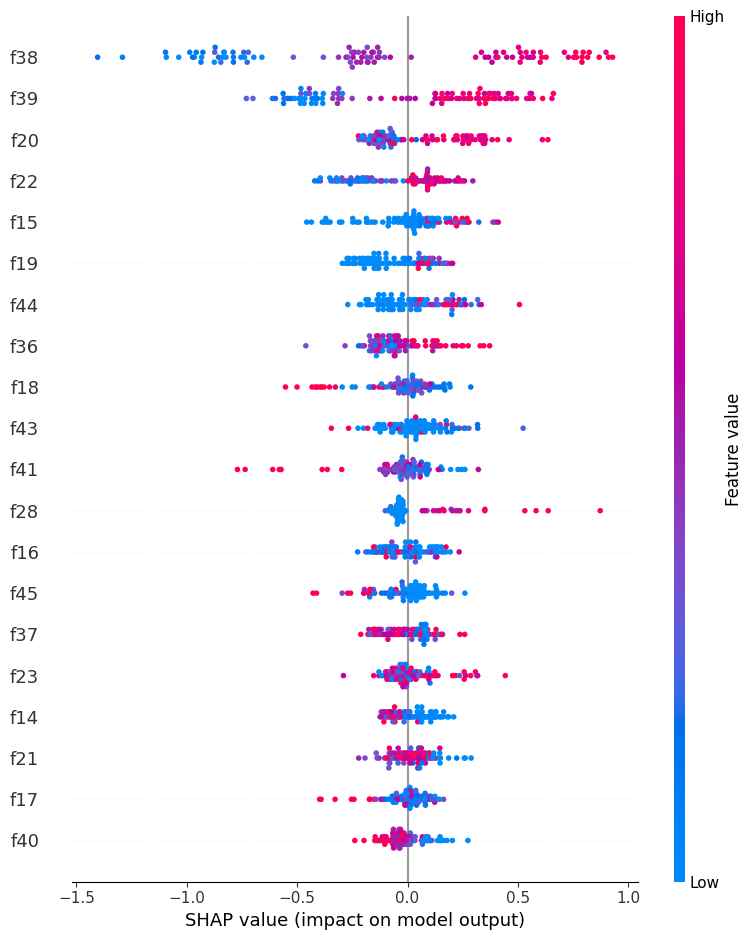

(100, 1872)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Leaf encoding shape: (100, 1872)


In [58]:
# (Optional) Interpret feature importance with SHAP
import shap
X_sample = x_train[:100].toarray()
X_df = pd.DataFrame(X_sample, columns=[f"f{i}" for i in range(X_sample.shape[1])])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df)

# Leaf-based encoding
x_leaf = get_leaf_index(x_train[:100], model_path)
print("Leaf encoding shape:", x_leaf.shape)